In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy import linalg
from sklearn.metrics import mean_squared_error


Выполнить прогноз временного ряда рекуррентным методом SSA (Singular Spectrum Analysis, "Гусеница") на M значений вперед. 
Для реализации метода SSA необходимо задать 2 параметра: 
L - ширина окна для построения траекторного пространства ряда, 
r- количество компонент, используемых для прогноза (r<L<N).
В качестве обучающей выборки использовали данные временных рядов из предыдущих лабораторных работ.


## Чтение данных

In [18]:
#исходные данные
data=pd.read_excel('C:/Users/artem/Documents/Учёба/7 сем/KM/РГЗ/rgz.xlsx')

In [19]:
class MSSA(object):
    """
    Объект многоканального анализа сингулярного спектра (MSSA).
Класс MSSA принимает один обязательный аргумент — временной ряд (timeseries).
:param timeseries: Тип данных может быть pandas.DataFrame, pandas.Series, numpy.array, numpy.matrix или список (list).
    """
    def __init__(self, time_series):
        self.ts_df = pd.DataFrame(time_series).reset_index(drop=True)
        self.ts = np.matrix(self.ts_df)
        self.ts_N = self.ts.shape[0]
        self.ts_s = self.ts.shape[1]
        self.ts_name = self.ts_df.columns.tolist()

    def _hankelSeries(self, series):
        """
        Perform hankelization procedure for given series
        """
        return linalg.hankel(series, np.zeros(self.embedding_dimension)).T[:, :self.K]

    def embed(self, embedding_dimension=None):
        """
        Вычисление матрицы траектории для заданного временного ряда.
:param embedding_dimension: Количество компонентов, которые нужно вычислить из исходного ряда. По умолчанию это N//2, где N — это длина ряда.
        """
        if not embedding_dimension:
            self.embedding_dimension = self.ts_N // 2
        else:
            self.embedding_dimension = embedding_dimension
        self.K = self.ts_N - self.embedding_dimension + 1
        series = np.hsplit(self.ts, self.ts_s)
        X = np.hstack(list(map(self._hankelSeries, series)))
        self.X = np.matrix(X)
        self.trajectory_dimentions = X.shape

    def decompose(self):
        """
        Выполните сингулярное разложение и определите ранг подпространства встраивания.
        """
        X = self.X
        self.S = X * X.T
        self.U, self.s, self.V = linalg.svd(self.S)
        self.U, self.s, self.V = np.matrix(self.U), np.sqrt(self.s), np.matrix(self.V)
        self.d = np.linalg.matrix_rank(X)
        self.Vs = (X.T * self.U) / self.s
        U_s = np.matrix(np.array(self.U) * self.s)
        Xs = np.empty((self.embedding_dimension, 0))
        for i in range(self.d):
            Xs = np.hstack((Xs, U_s[:, i] * self.Vs[:, i].T))
        self.Xs = Xs

    @staticmethod
    def _diagonal_averaging(hankel_matrix):
        """
        Выполняет антидиагональное усреднение для заданной матрицы Ханкеля  
:param embedding_dimension: Траекторная матрица одномерного временного ряда.  
:return: pandas.DataFrame с разложенными рядами.
        """
        mat = np.matrix(hankel_matrix)
        L, K = mat.shape
        L_star, K_star = min(L, K), max(L, K)
        if L > K:
            mat = mat.T
        ret = []
        # Diagonal Averaging
        for k in range(1 - K_star, L_star):
            mask = np.eye(K_star, k=k, dtype='bool')[::-1][:L_star, :]
            mask_n = sum(sum(mask))
            ma = np.ma.masked_array(mat.A, mask=1 - mask)
            ret += [ma.sum() / mask_n]
        return ret

    def _d_series_diag(self, Xd):
        '''Diagonal averaging for d series matrix'''
        sreries = list(map(self._diagonal_averaging, np.hsplit(Xd, self.ts_s)))
        return np.hstack(sreries)

    def diag_procedure(self):
        '''Performs anti-diagonal averaging for multidimensional time series.'''
        _hankel_list = np.hsplit(self.Xs, self.d)
        _big_vector = np.vstack(list(map(self._d_series_diag, _hankel_list))).T
        return np.hstack(np.vsplit(_big_vector, self.ts_s))

    def group_components(self, r, return_df=False):
        '''Вычисляет сумму первых \(r\) выбранных компонентов из разложенного ряда (процедура реконструкции).  

:param r: Количество компонентов для реконструкции ряда.  
:param return_df: Если True, возвращает pandas.DataFrame с реконструированными рядами.  
:return: pandas.DataFrame с реконструированными рядами.'''
        self.r = r
        C = self.diag_procedure()
        C_grouped = np.hsplit(C, self.ts_s)
        res = []
        for i in range(len(C_grouped)):
            res.append(
                np.sum(C_grouped[i][:, :r], axis=1)
            )

        ### Resids part ###############
        resids = []
        for i in range(len(C_grouped)):
            resids.append(
                np.sum(C_grouped[i][:, r:], axis=1)
            )
        self.resids = np.matrix(resids)
        ###############################

        self.C_grouped = np.matrix(res)
        if return_df == True:
            return pd.DataFrame(res, index=['Grouped_component_' + str(i) for i in self.ts_name]).T

    def L_reccurent_forecast(self, steps_ahead):
        '''Вычисляет рекуррентный прогноз на основе столбцов (MSSA-L).  

:param steps_ahead: Длина прогноза (сколько шагов вперёд вычислить).  
:return: pandas.DataFrame с реконструированными рядами и их прогнозами.'''

        r = self.r
        v_2 = 0
        for i in range(r):
            v_2 += (self.U[-1, i]) ** 2
        R_L_sum = 0
        for i in range(r):
            R_L_sum += self.U[-1, i] * self.U[:-1, i] #сумма произведений последних элементов self.U
        R_L = (1 / (1 - v_2)) * R_L_sum #рекуррентный коэффициент прогнозирования
        C_grp_forc = self.C_grouped
        N = self.ts_N
        for i in range(steps_ahead):
            Z = C_grp_forc[:, N - self.embedding_dimension + 1:]
            R_N = np.dot(Z, R_L)
            C_grp_forc = np.hstack((C_grp_forc, R_N))
            N += 1

        self.forc = C_grp_forc
        self.reccurent_coef = R_L
        self.steps_ahead = steps_ahead
        return pd.DataFrame(C_grp_forc, index=['Forecast_' + str(i) for i in self.ts_name]).T

    

    @staticmethod
    def _recursive_coef_calc(a, steps):
        a = np.array(sum(a.tolist(), []))
        psy_list = []
        psy = np.zeros((len(a), 1))
        psy[0] = 1
        for i in range(steps):
            psy_j = np.dot(a, psy).prod()
            psy = np.roll(psy, 1)
            psy[0] = psy_j
            psy_list.append(psy_j ** 2)
        return psy_list

    def conf_int(self):
        '''
        Построить доверительные интервалы для всех прогнозируемых рядов  
        :return: pandas DataFrame с доверительными интервалами в том же порядке, что и ряды в исходной таблице.
        '''
        intervals = []
        out_col_names = []
        for r in range(len(self.resids)):
            mu, std = norm.fit(np.squeeze(np.asarray(self.resids[r])))
            p5 = np.percentile(np.squeeze(np.asarray(self.resids[r])) - mu, 5)
            p95 = np.percentile(np.squeeze(np.asarray(self.resids[r])) - mu, 95)

            recursive_coefs = self._recursive_coef_calc(self.reccurent_coef, self.steps_ahead)
            recursive_coefs = [1] + recursive_coefs
            forc_interval = []
            for i in range(self.steps_ahead):
                forc_interval.append(
                    sum(recursive_coefs[:i+1])*(std**2)
                )

            upper_bound_in = (np.squeeze(np.array(self.forc[r, :-self.steps_ahead])) + p95).tolist()
            lower_bound_in = (np.squeeze(np.array(self.forc[r, :-self.steps_ahead])) + p5).tolist()
            upper_bound_out = (np.squeeze(np.array(self.forc[r, -self.steps_ahead:])) + np.sqrt(np.array(forc_interval))*1.96).tolist()
            lower_bound_out = (np.squeeze(np.array(self.forc[r, -self.steps_ahead:])) - np.sqrt(np.array(forc_interval))*1.96).tolist()
            intervals.append(lower_bound_in + lower_bound_out)
            intervals.append(upper_bound_in + upper_bound_out)

            out_col_names += ["conf. 5%", "conf. 95%"]
        conf_int_df = pd.DataFrame(intervals).T
        conf_int_df.columns = out_col_names
        return conf_int_df

## Мерные интервалы

Значений в выборке 225
/nОбучающая выборка: 0.25
Интервал: 145 - 201
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b

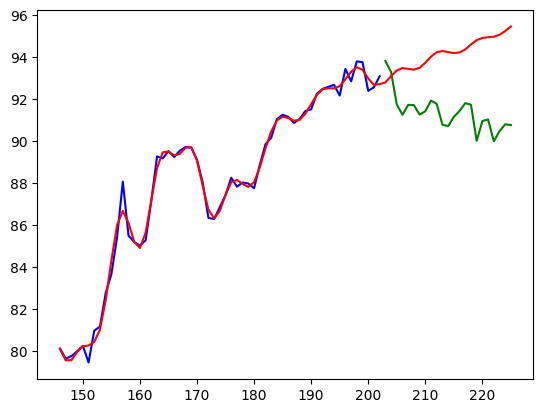

/nОбучающая выборка: 0.5
Интервал: 89 - 201
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length 

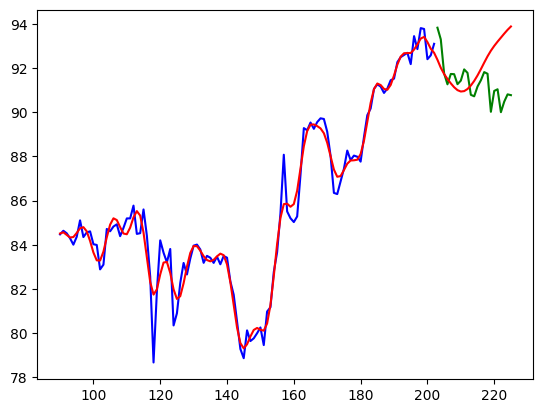

/nОбучающая выборка: 0.75
Интервал: 33 - 201
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length

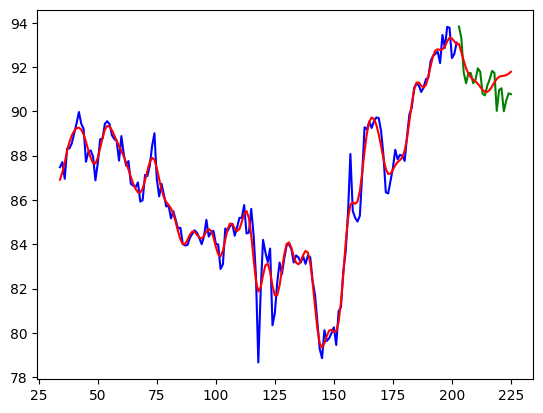

/nОбучающая выборка: 0.9
Интервал: 0 - 201
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b 23 
length b

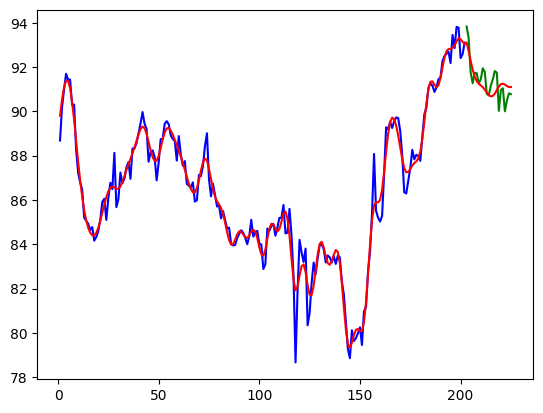

In [20]:
print(f'Значений в выборке {len(data)}')

# Определяем часть, отведённую для обучения
train_part = 9/10
#интервалы
intervals=[1/4,1/2,3/4,9/10]
end=[]
start=[]
cnt=0
for interval in intervals:
    end.append(int(train_part * len(data)))
    start.append(int (end[cnt] - interval * len(data)))
    cnt+=1


train_y=[]
train_x=[]
train_d=[]
test_x=[]
test_y=[]
test_d=[]





data.drop('Дата', axis=1, inplace=True)
for i in range(len(intervals)):
    
    print(f'/nОбучающая выборка: {intervals[i]}')
    print(f'Интервал: {start[i]} - {end[i] - 1}')
    
    #расскоментить
    train_y.append(data[start[i]:end[i]]['Курс'].to_numpy())
    train_x.append(data[start[i]:end[i]]['k'].to_numpy())
    
    
    #расскоментить
    test_y.append(data[end[i]:]['Курс'].to_numpy())
    test_x.append((data[end[i]:]['k'].to_numpy()))
   
   
    #прогнозирование
    n_predict=len(test_y[i])
    best_components=5
    best_size=5
    best_rmse=float("inf")
    
    for windows_size in range(5,min(30,len(train_y[i]))):
        for components in range(5,min(16,windows_size//2)):
            ssa=MSSA(data[start[i]:end[i]].set_index('k'))
            ssa.embed(embedding_dimension=windows_size)
            ssa.decompose()
            ssa.group_components(components)
            data_ssa=ssa.L_reccurent_forecast(len(test_y[i]))
            #rmse = np.sqrt(mean_squared_error(test_y[i], data_ssa[:len(test_y[i])])) ** 0.5
            #print(test_x[i],test_y[i],len(test_y[i]))
            #print(("length", len(data_ssa)-len(test_y[i])))
            a=(len(data_ssa)-len(test_y[i]))

            b=(len(data_ssa)-len(train_y[i]))
            print(f'length b {b} ')
            
            rmse = np.sqrt(mean_squared_error(test_y[i], data_ssa[a:])) ** 0.5
            #print("a> \n", data_ssa[a:])
            #rmse = np.sqrt(mean_squared_error(train_y[i], data_ssa[:len(train_y[i])])) ** 0.5
            dates=np.concatenate([train_x[i],test_x[i]])
       
            
            if rmse<best_rmse:
                best_components=components
                best_size=windows_size
                best_rmse=rmse
            
           
    print("тестовая часть интервала s> ", test_x[i],test_y[i])
    
    ssa=MSSA(data[start[i]:end[i]].set_index('k'))
    ssa.embed(embedding_dimension=best_size)
    ssa.decompose()
    ssa.group_components(best_components)
    data_ssa=ssa.L_reccurent_forecast(len(test_y[i]))
           
    dates=np.concatenate([train_x[i],test_x[i]])

    plt.plot(train_x[i],train_y[i],label='Тренировочные данные',color='blue')
    plt.plot(test_x[i],test_y[i],label='Тестовые данные',color='green')
    plt.plot(dates,data_ssa,label='Модель',color='red')
    
    print(f'best window {best_size}, best components {best_components}, rmse {rmse}')
    
    plt.show()         
    
           
          
    
   
    
   

     Forecast_Курс
223      90.680094
224      90.576821
225      90.145017
226      89.765007
227      89.573166
228      89.537797
229      89.581413
230      89.671702
231      89.759748
232      89.757097
Длины  225 233
Длины  233 233


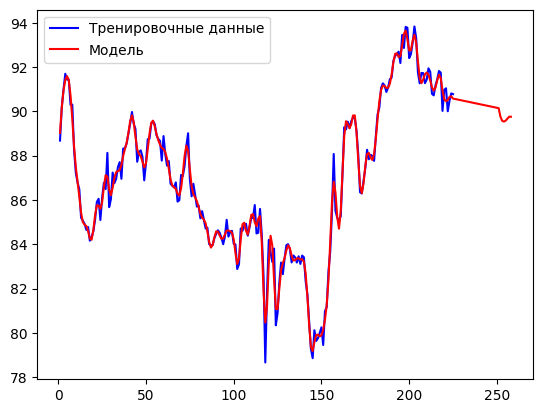

In [21]:
train_y=[]
train_x=[]
train_y.append(data['Курс'].to_numpy())
train_x.append(data['k'].to_numpy())

#print(train_x,test_y)

#прогнозирование
n_predict=len(test_y)
best_components=5
best_size=5
best_rmse=float("inf")

windows_size=23
components=10
ssa=MSSA(data.set_index('k'))
ssa.embed(embedding_dimension=windows_size)
ssa.decompose()
ssa.group_components(components)
data_ssa=ssa.L_reccurent_forecast(8)
            #rmse = np.sqrt(mean_squared_error(test_y[i], data_ssa[:len(test_y[i])])) ** 0.5
            #print(test_x[i],test_y[i],len(test_y[i]))
            #print((len(data_ssa)-len(test_y[i])))
#a=(len(data_ssa)-len(train_y))
#rmse = np.sqrt(mean_squared_error(test_y[i], data_ssa[a:])) ** 0.5
            #print(data_ssa[a:])
            #rmse = np.sqrt(mean_squared_error(train_y[i], data_ssa[:len(train_y[i])])) ** 0.5
#dates=np.concatenate([train_x[i],test_x[i]])           
       
            
      


#print(train_x,train_y)
print(data_ssa.tail(10))
plt.plot(train_x[0],train_y[0],label='Тренировочные данные',color='blue')


print("Длины ", len(train_x[0]), len(data_ssa))
x=np.concatenate([train_x[0],np.arange(251,259)]) # поменять числа в arrange в зависимости от того сколько будет нехватать длины train_x[0] lj длины data_ssa
print("Длины ", len(x), len(data_ssa))


plt.plot(x,data_ssa,label='Модель',color='red')
plt.legend()
# print(x[267],data_ssa.iloc[267])
# print(x[268],data_ssa.iloc[268])
# print(x[269],data_ssa.iloc[269])
# print(x[270],data_ssa.iloc[270])
# print(x[271],data_ssa.iloc[271])
    
plt.show()         

[9911.04243585  258.40853078   39.32475757   23.90773334   19.2337279 ]


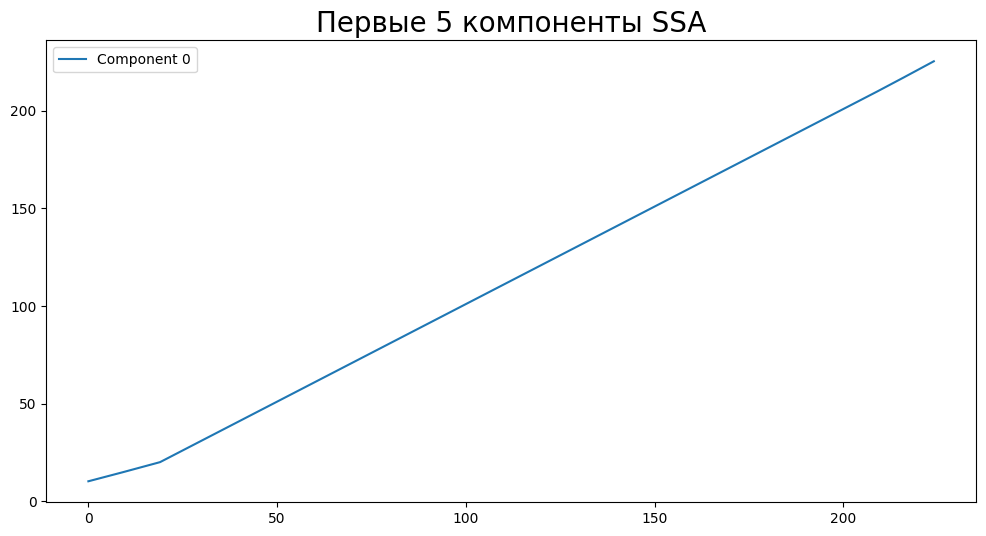

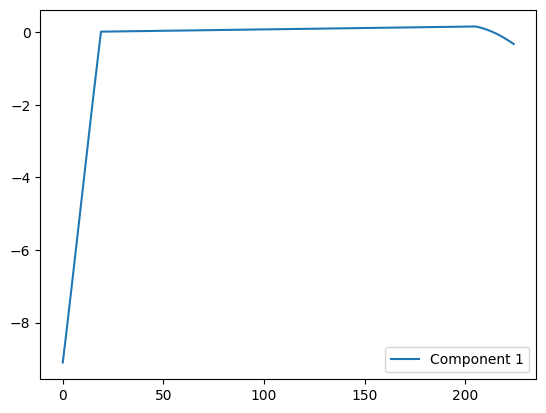

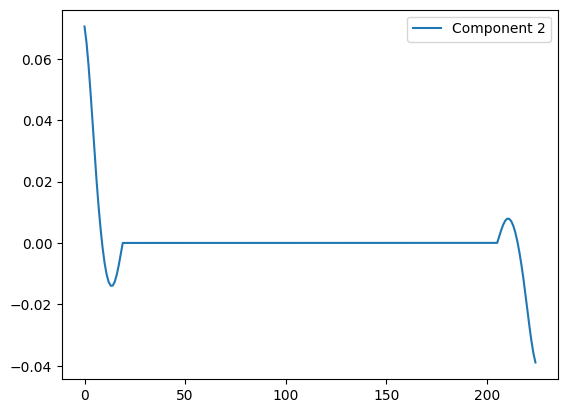

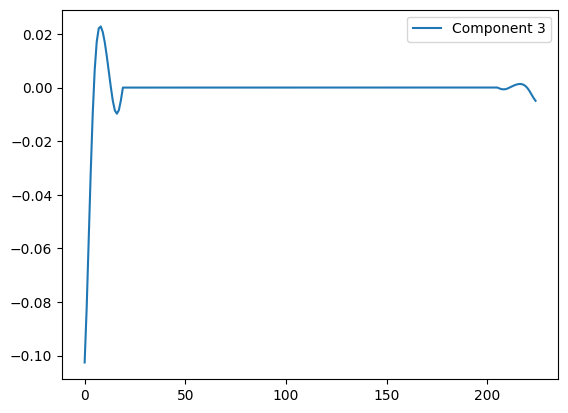

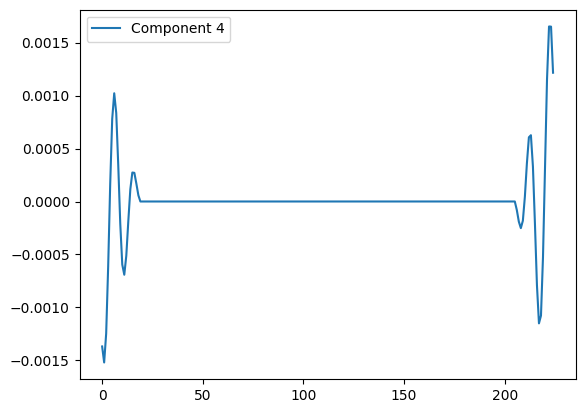

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy import linalg
from sklearn.metrics import mean_squared_error
data=pd.read_excel('rgz.xlsx')
data.drop('Дата', axis=1, inplace=True)
ssa = MSSA(data)
ssa.embed(embedding_dimension=20)
ssa.decompose()
b = ssa.diag_procedure()

#print(b)
#print(b.shape)

print(ssa.s[:5])


plt.figure(figsize=(12,6))
plt.title("Первые 5 компоненты SSA", fontsize=20)
for i in range(5):
    plt.plot(b[:,i], label="Component %s"%i)
    
    plt.legend()
    plt.show()